### Importing Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
companies=pd.read_csv("companies.csv", encoding="ISO-8859-1")
rounds2=pd.read_csv("rounds2.csv", encoding="ISO-8859–1")

A preliminary look at the Datasets Companies and Rounds2 has given the below details, 
Companies shape is of (66368, 10)
Rounds2 shape is of (114949, 6)
Apart from raised_amount_usd in rounds2 dataset which is Float, all other are of Dtype Object

### Data Cleaning

In [3]:
companies.isnull().sum()

permalink            0
name                 1
homepage_url      5058
category_list     3148
status               0
country_code      6958
state_code        8547
region            8030
city              8028
founded_at       15221
dtype: int64

In [4]:
rounds2.isnull().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
dtype: int64

In [5]:
companies.permalink = companies.permalink.str.lower()

In [6]:
rounds2.company_permalink = rounds2.company_permalink.str.lower()

In [7]:
rounds2['company_permalink'].nunique()

66370

In [8]:
companies['permalink'].nunique()

66368

Verified across these companies in the Excel. Both of the datasets 'Companies' and 'Rounds2' have all the companies listed below. The difference is in the ASCII value at the end of the permalink, probably due to encoding. Therefore there are no companies in Rounds2 that are not there in Companies dataset. 

In [9]:
set(companies['permalink'].unique()).difference(set(rounds2['company_permalink'].unique()))

{'/organization/e-cã\x9abica',
 '/organization/energystone-games-ç\x81µçÿ³æ¸¸æ\x88\x8f',
 '/organization/huizuche-com-æ\x83\xa0ç§\x9fè½¦',
 '/organization/tipcat-interactive-æ²\x99è\x88\x9fä¿¡æ\x81¯ç§\x91æ\x9a\x80',
 '/organization/zengame-ç¦\x85æ¸¸ç§\x91æ\x9a\x80'}

### Merging Datasets

In [10]:
master_frame= pd.merge(companies, rounds2,left_on="permalink",right_on="company_permalink",how='right')

The master frame now consists of combined columns of Companies and Rounds2. Summing up the missing values (column-wise) in merged data frame

In [11]:
master_frame.isnull().sum()

permalink                      7
name                           8
homepage_url                6139
category_list               3414
status                         7
country_code                8678
state_code                 10946
region                     10167
city                       10164
founded_at                 20527
company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         83809
funded_at                      0
raised_amount_usd          19990
dtype: int64

Calaculating pecentage of null values - column-wise

In [12]:
round(100*(master_frame.isnull().sum()/len(master_frame.index)), 2)

permalink                   0.01
name                        0.01
homepage_url                5.34
category_list               2.97
status                      0.01
country_code                7.55
state_code                  9.52
region                      8.84
city                        8.84
founded_at                 17.86
company_permalink           0.00
funding_round_permalink     0.00
funding_round_type          0.00
funding_round_code         72.91
funded_at                   0.00
raised_amount_usd          17.39
dtype: float64

AS fundind round has more then 30% of null values, droping funding_round_code

In [13]:
master_frame=master_frame.drop('funding_round_code', axis=1) 


In [14]:
master_frame.shape

(114949, 15)

Converting raised_amount_usd into Million (USD) by creating a new column million_usd

In [15]:
master_frame['million_usd']=round(master_frame['raised_amount_usd']/1000000,4)

In [16]:
master_frame['million_usd'].describe()

count    94959.000000
mean        10.426869
std        114.821248
min          0.000000
25%          0.322500
50%          1.680500
75%          7.000000
max      21271.935000
Name: million_usd, dtype: float64

The null values present in million_usd is around 17.3%. Therefore choosing to fill it with median or mean rather than deleting those rows. Since the difference between the 75% and max is very large, suggesting the presence of high value outliers that can influence mean. I choose the median to fill the empty values

In [17]:
master_frame['raised_amount_usd'].fillna(master_frame['raised_amount_usd'].median(), inplace=True)

In [18]:
master_frame['million_usd'].fillna(master_frame['million_usd'].median(), inplace=True)

In [19]:
master_frame.isnull().sum()

permalink                      7
name                           8
homepage_url                6139
category_list               3414
status                         7
country_code                8678
state_code                 10946
region                     10167
city                       10164
founded_at                 20527
company_permalink              0
funding_round_permalink        0
funding_round_type             0
funded_at                      0
raised_amount_usd              0
million_usd                    0
dtype: int64

after filling with median values, the count has increased. No major variation found with respect to mean and quantiles. 

In [20]:
master_frame.million_usd.describe()

count    114949.000000
mean          8.905848
std         104.413424
min           0.000000
25%           0.500000
50%           1.680500
75%           5.000000
max       21271.935000
Name: million_usd, dtype: float64

Calculating the quantiles of 90%,95%,99% and we can also check the differnce and investigate the presence of Outliers as the difference between 75% and Max is very large

In [21]:
high = 0.95
quant_master_frame = master_frame['million_usd'].quantile([high])
quant_master_frame

0.95    30.0
Name: million_usd, dtype: float64

### Choosing particular Funding Investment Type

In [28]:
master_frame['funding_round_type'] = master_frame['funding_round_type'].str.lower()

In [29]:
master_frame_segment = master_frame.groupby('funding_round_type')

In [31]:
master_frame_segment.million_usd.describe()

,count,mean,std,min,25%,50%,75%,max
funding_round_type,,,,,,,,
angel,6094.0,1.104856,6.618584,0.0,0.2000,0.600,1.6805,494.5120
private_equity,2285.0,62.368460,184.162554,0.0,1.6805,12.122,62.4000,4745.4602
seed,30524.0,0.937643,1.994660,0.0,0.1000,0.575,1.6805,200.0000
venture,55494.0,10.793522,82.205753,0.0,1.6805,4.000,10.5000,17600.0000


Dropping the rows which are not required as we need only angel,seed,venture,private_equity

In [32]:
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "convertible_note"], inplace = True)
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "debt_financing"], inplace = True)
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "equity_crowdfunding"], inplace = True)
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "grant"], inplace = True)
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "non_equity_assistance"], inplace = True)
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "post_ipo_debt"], inplace = True)
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "post_ipo_equity"], inplace = True)
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "product_crowdfunding"], inplace = True)
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "secondary_market"], inplace = True)
master_frame.drop(master_frame.index[master_frame['funding_round_type'] == "undisclosed"], inplace = True)

Have taken mean of the funding type investments for representative value investment for each of the chosen funding types

In [33]:
master_frame_segment.million_usd.describe()

,count,mean,std,min,25%,50%,75%,max
funding_round_type,,,,,,,,
angel,6094.0,1.104856,6.618584,0.0,0.2000,0.600,1.6805,494.5120
private_equity,2285.0,62.368460,184.162554,0.0,1.6805,12.122,62.4000,4745.4602
seed,30524.0,0.937643,1.994660,0.0,0.1000,0.575,1.6805,200.0000
venture,55494.0,10.793522,82.205753,0.0,1.6805,4.000,10.5000,17600.0000


Venture investment is most suitable from the above data, creaitng another dataframe for easy analysis

In [34]:
venture_frame=master_frame[master_frame['funding_round_type'] == ("venture")]

In [35]:
venture_frame.isnull().sum()

permalink                      1
name                           1
homepage_url                2946
category_list               1132
status                         1
country_code                2875
state_code                  3796
region                      3554
city                        3554
founded_at                 11192
company_permalink              0
funding_round_permalink        0
funding_round_type             0
funded_at                      0
raised_amount_usd              0
million_usd                    0
dtype: int64

### Choosing top 3 Countries for Invesment (Venture)

Dropping the rows which are empty values in country_code

In [36]:
venture_frame = venture_frame[~venture_frame.country_code.isnull()]

In [37]:
venture_frame.isnull().sum()

permalink                     0
name                          0
homepage_url               2318
category_list               595
status                        0
country_code                  0
state_code                  921
region                      679
city                        679
founded_at                 9666
company_permalink             0
funding_round_permalink       0
funding_round_type            0
funded_at                     0
raised_amount_usd             0
million_usd                   0
dtype: int64

In [38]:
venture_grouped = venture_frame.groupby("country_code").sum()

In [39]:
venture_sort = venture_grouped.sort_values(by = "million_usd", ascending = False)

In [40]:
venture_sort

,raised_amount_usd,million_usd
country_code,,
USA,4.262634e+11,426263.3991
CHN,4.071433e+10,40714.3209
GBR,2.066239e+10,20662.3934
IND,1.467418e+10,14674.1829
CAN,9.734578e+09,9734.5769
...,...,...
ECU,9.658500e+05,0.9658
MCO,6.570000e+05,0.6570
SAU,5.000000e+05,0.5000


In [41]:
top9 = venture_sort.iloc[:9]

In [42]:
top9

,raised_amount_usd,million_usd
country_code,,
USA,4.262634e+11,426263.3991
CHN,4.071433e+10,40714.3209
GBR,2.066239e+10,20662.3934
IND,1.467418e+10,14674.1829
CAN,9.734578e+09,9734.5769
FRA,7.373811e+09,7373.8104
ISR,7.099093e+09,7099.0912
DEU,6.730116e+09,6730.1130
JPN,3.437619e+09,3437.6188


The top english speaking countries to be chosen for investment are: USA, GBR (UK) & IND

### Choosing Top 3 Sectors from Each Country

In [43]:
mapping=pd.read_csv("mapping.csv", encoding="ISO-8859-1")

Creating new column primary_sector from Category_List so that the first category given in the list for a specific company is chosen

In [44]:
venture_frame['primary_sector'] = venture_frame['category_list'].str.split('|').str[0]

In [45]:
venture_frame['primary_sector']

0                         Media
1         Application Platforms
4                   Curated Web
5                      Software
8                 Biotechnology
                  ...          
114931            Biotechnology
114934               E-Commerce
114936            Biotechnology
114937            Biotechnology
114941      Enterprise Software
Name: primary_sector, Length: 52619, dtype: object

Converting of mapping .csv from wide format to long format to create main_sector variable

In [46]:
mapping=pd.melt(mapping, id_vars='category_list', value_vars=['Automotive & Sports', 'Cleantech / Semiconductors', 'Entertainment','Health','Manufacturing','News, Search and Messaging','Others','Social, Finance, Analytics, Advertising'])

In [47]:
mapping = mapping.rename(columns = {"variable":"main_sector"})

In [48]:
mapping=mapping[mapping['value']==1]

In [49]:
mapping

,category_list,main_sector,value
8,Adventure Travel,Automotive & Sports,1
14,Aerospace,Automotive & Sports,1
45,Auto,Automotive & Sports,1
46,Automated Kiosk,Automotive & Sports,1
47,Automotive,Automotive & Sports,1
...,...,...,...
5433,Social Recruiting,"Social, Finance, Analytics, Advertising",1
5434,Social Television,"Social, Finance, Analytics, Advertising",1
5435,Social Travel,"Social, Finance, Analytics, Advertising",1
5446,Stock Exchanges,"Social, Finance, Analytics, Advertising",1


Merging venture_frame and mapping data frames to identify 3 main sectors

In [51]:
venture_frame1=pd.merge(venture_frame, mapping,left_on="primary_sector",right_on="category_list",how="left")

Creating three separate data frames D1, D2 and D3 for each of the three countries (UK, USA, IND) containing the observations of funding type FT falling within the 5-15 million USD range.

In [52]:
D1=venture_frame1[venture_frame1['country_code'] == ("USA")]

In [53]:
D1=D1[(D1['million_usd']>=5)&(D1['million_usd']<=15)]

In [54]:
D1_segment=D1.groupby('main_sector')

In [55]:
D1_segment.million_usd.describe()

,count,mean,std,min,25%,50%,75%,max
main_sector,,,,,,,,
Automotive & Sports,167.0,8.707213,2.981831,5.0,6.000,8.1815,10.950,15.0
Cleantech / Semiconductors,2301.0,9.222514,3.112481,5.0,6.500,9.0000,12.000,15.0
Entertainment,580.0,8.621057,3.054328,5.0,6.000,8.0000,10.425,15.0
Health,912.0,9.036029,3.102049,5.0,6.100,8.6000,11.200,15.0
Manufacturing,803.0,9.089107,3.023879,5.0,6.465,8.8000,11.175,15.0
"News, Search and Messaging",1567.0,8.817368,3.071449,5.0,6.000,8.0000,10.800,15.0
Others,2928.0,8.922227,3.067431,5.0,6.000,8.2500,11.000,15.0
"Social, Finance, Analytics, Advertising",1915.0,8.723600,3.078441,5.0,6.000,8.0000,10.700,15.0


The top three sectors in USA: Others > CleanTech/ Semiconductors > Social, Finance, Analytics, Advertising

In [56]:
round(D1_segment.million_usd.sum(),2)

main_sector
Automotive & Sports                         1454.10
Cleantech / Semiconductors                 21221.00
Entertainment                               5000.21
Health                                      8240.86
Manufacturing                               7298.55
News, Search and Messaging                 13816.82
Others                                     26124.28
Social, Finance, Analytics, Advertising    16705.69
Name: million_usd, dtype: float64

In [57]:
D11=D1[D1['main_sector'] == ("Others")]

In [58]:
D11 = D11.pivot_table(values = 'million_usd', index = 'company_permalink', aggfunc = 'sum')
D11 = D11.sort_values(by = 'million_usd', ascending = False).head()
print(D11.head(1))

                           million_usd
company_permalink                     
/organization/virtustream         64.3


In [59]:
D111=D1[D1['main_sector'] == ("Cleantech / Semiconductors")]

In [60]:
D111 = D111.pivot_table(values = 'million_usd', index = 'company_permalink', aggfunc = 'sum')
D111 = D111.sort_values(by = 'million_usd', ascending = False).head()
print(D111.head(1))

                        million_usd
company_permalink                  
/organization/biodesix         75.3


In [61]:
D2=venture_frame1[venture_frame1['country_code'] == ("GBR")]

In [62]:
D2=D2[(D2['million_usd']>=5)&(D2['million_usd']<=15)]

In [63]:
D2_segment=D2.groupby('main_sector')

In [64]:
D2_segment.million_usd.describe()

,count,mean,std,min,25%,50%,75%,max
main_sector,,,,,,,,
Automotive & Sports,16.0,10.440725,3.371173,5.1331,7.489775,10.94500,13.000000,15.0
Cleantech / Semiconductors,127.0,8.952010,2.925980,5.0000,6.139550,8.42000,11.490000,15.0
Entertainment,54.0,8.546504,2.705239,5.0000,5.850000,8.48415,10.136275,15.0
Health,24.0,8.939054,3.133504,5.0000,6.299425,7.84605,11.512050,14.3
Manufacturing,42.0,8.617624,2.762393,5.0000,6.500000,7.96520,10.000000,15.0
"News, Search and Messaging",73.0,8.434882,2.659227,5.0000,6.080000,7.52000,10.000000,15.0
Others,144.0,8.778642,3.004506,5.0000,6.235000,8.00000,10.632500,15.0
"Social, Finance, Analytics, Advertising",98.0,8.386617,2.666610,5.0000,6.000000,8.00000,10.250575,15.0


The top three sectors in UK: Others > CleanTech/ Semiconductors > Social, Finance, Analytics, Advertising

In [65]:
round(D2_segment.million_usd.sum(),2)

main_sector
Automotive & Sports                         167.05
Cleantech / Semiconductors                 1136.91
Entertainment                               461.51
Health                                      214.54
Manufacturing                               361.94
News, Search and Messaging                  615.75
Others                                     1264.12
Social, Finance, Analytics, Advertising     821.89
Name: million_usd, dtype: float64

In [66]:
D22=D2[D2['main_sector'] == ("Others")]

In [67]:
D22 = D22.pivot_table(values = 'million_usd', index = 'company_permalink', aggfunc = 'sum')
D22 = D22.sort_values(by = 'million_usd', ascending = False).head()
print(D22.head(1))

                              million_usd
company_permalink                        
/organization/electric-cloud         37.0


In [68]:
D222=D2[D2['main_sector'] == ("Cleantech / Semiconductors")]

In [69]:
D222 = D222.pivot_table(values = 'million_usd', index = 'company_permalink', aggfunc = 'sum')
D222 = D222.sort_values(by = 'million_usd', ascending = False).head()
print(D222.head(1))

                           million_usd
company_permalink                     
/organization/eusa-pharma         35.6


In [70]:
D3=venture_frame1[venture_frame1['country_code'] == ("IND")]

In [71]:
D3=D3[(D3['million_usd']>=5)&(D3['million_usd']<=15)]

In [72]:
D3_segment=D3.groupby('main_sector')

In [73]:
D3_segment.million_usd.describe()

,count,mean,std,min,25%,50%,75%,max
main_sector,,,,,,,,
Automotive & Sports,13.0,10.530769,3.974373,5.0,6.5000,11.0,15.00,15.00
Cleantech / Semiconductors,20.0,8.269000,3.173212,5.0,5.3975,8.0,9.85,15.00
Entertainment,33.0,8.510000,3.102527,5.0,6.0000,8.0,10.00,15.00
Health,19.0,8.828421,2.200690,5.0,7.5000,9.0,10.00,13.08
Manufacturing,21.0,9.566667,2.982798,5.0,8.0000,10.0,10.00,15.00
"News, Search and Messaging",52.0,8.342973,2.698079,5.0,5.9250,8.0,10.00,15.00
Others,109.0,9.242289,3.444908,5.0,6.0000,9.0,12.00,15.00
"Social, Finance, Analytics, Advertising",32.0,9.079484,3.362389,5.0,6.0000,9.0,10.53,15.00


The top three sectors in IND: Others > News, Search and Messaging > Entertainment

In [74]:
round(D3_segment.million_usd.sum(),2)

main_sector
Automotive & Sports                         136.90
Cleantech / Semiconductors                  165.38
Entertainment                               280.83
Health                                      167.74
Manufacturing                               200.90
News, Search and Messaging                  433.83
Others                                     1007.41
Social, Finance, Analytics, Advertising     290.54
Name: million_usd, dtype: float64

In [75]:
D33=D3[D3['main_sector'] == ("Others")]

In [76]:
D33 = D33.pivot_table(values = 'million_usd', index = 'company_permalink', aggfunc = 'sum')
D33 = D33.sort_values(by = 'million_usd', ascending = False).head()
print(D33.head(1))

                            million_usd
company_permalink                      
/organization/firstcry-com         39.0


In [77]:
D333=D3[D3['main_sector'] == ('News, Search and Messaging')]

In [78]:
D333 = D333.pivot_table(values = 'million_usd', index = 'company_permalink', aggfunc = 'sum')
D333 = D333.sort_values(by = 'million_usd', ascending = False).head()
print(D333.head(1))

                                                million_usd
company_permalink                                          
/organization/gupshup-technology-india-pvt-ltd         33.0


### Plots

In [79]:
import matplotlib.pyplot as plt

The avg funding for each investment

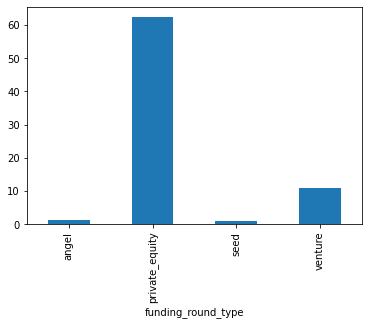

In [95]:
master_frame_segment['million_usd'].mean().plot.bar()
plt.show()

Top 9 countries with Venture Investment Funding Type

<AxesSubplot:xlabel='country_code'>

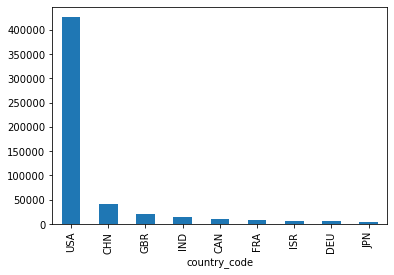

In [82]:
top9['million_usd'].plot.bar()

In [83]:
D1_plot = D1

D1_plot = D1_plot.groupby("main_sector").million_usd.count().reset_index()
D1_plot.sort_values(["million_usd"],axis=0,ascending=False,inplace=True)
D1_plot = D1_plot.head(3)

In [84]:
D1_plot

,main_sector,million_usd
6,Others,2928
1,Cleantech / Semiconductors,2301
7,"Social, Finance, Analytics, Advertising",1915


In [85]:
D2_plot = D2

D2_plot = D2_plot.groupby("main_sector").million_usd.count().reset_index()
D2_plot.sort_values(["million_usd"],axis=0,ascending=False,inplace=True)
D2_plot = D2_plot.head(3)

In [86]:
D2_plot

,main_sector,million_usd
6,Others,144
1,Cleantech / Semiconductors,127
7,"Social, Finance, Analytics, Advertising",98


In [87]:
D3_plot = D3

D3_plot = D3_plot.groupby("main_sector").million_usd.count().reset_index()
D3_plot.sort_values(["million_usd"],axis=0,ascending=False,inplace=True)
D3_plot = D3_plot.head(3)

In [88]:
D3_plot

,main_sector,million_usd
6,Others,109
5,"News, Search and Messaging",52
2,Entertainment,33


In [89]:
D12 = pd.merge(D1_plot,D2_plot,how='outer',on='main_sector')

In [90]:
D123 = pd.merge(D12,D3_plot,how='outer',on='main_sector')

In [91]:
D123

,main_sector,million_usd_x,million_usd_y,million_usd
0,Others,2928.0,144.0,109.0
1,Cleantech / Semiconductors,2301.0,127.0,NaN
2,"Social, Finance, Analytics, Advertising",1915.0,98.0,NaN
3,"News, Search and Messaging",NaN,NaN,52.0
4,Entertainment,NaN,NaN,33.0


In [92]:
D123 = D123.rename(columns={"million_usd_x": "USA", "million_usd_y": "GBR(UK)" ,"million_usd": "IND"})
D123= D123.set_index("main_sector")
D123.fillna(0)

,USA,GBR(UK),IND
main_sector,,,
Others,2928.0,144.0,109.0
Cleantech / Semiconductors,2301.0,127.0,0.0
"Social, Finance, Analytics, Advertising",1915.0,98.0,0.0
"News, Search and Messaging",0.0,0.0,52.0
Entertainment,0.0,0.0,33.0


Top three sectors in top three english speaking countries for investment funding type, Venture (vs. investment count)

<AxesSubplot:>

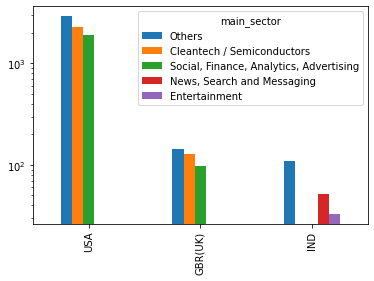

In [93]:
D123.T.plot.bar(logy=True)